Import the library with all predefine functions

In [1]:
import lazy_pipeline as lpipe
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import time

# preprocessing of numeric features
from sklearn.preprocessing import KBinsDiscretizer

# used metrics
from sklearn.metrics import accuracy_score, f1_score


Make the notebook wider

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Check library versions

In [3]:
from platform import python_version
import sklearn

print(python_version())
print(lpipe.pd.__version__)
print(sklearn.__version__)
print(pd.__version__)
print(np.__version__)

3.7.6
1.0.1
0.22.1
1.0.1
1.18.1


# Start of baseline

In [4]:
def process_data(df):

    # dataset preprocessing, replacing empty numeric values with column averages, categorical values unknown
    # I keep no more than 10 of the most popular values of each categorical attribute
    
    for col in df.select_dtypes(['number']).columns:
        df[col] = df[col].fillna(df[col].mean())
        
    for col in df.select_dtypes(['object']).columns:
        df[col] = df[col].fillna('unknown')
        use_values = df[col].value_counts().index.values[0:10]
        df[col] = df[col].apply(lambda x: x if x in use_values else 'other')
    
    return df
            
    
def discretize_data(df):
    
    # categorize the numerical features: divide into 5 intervals of equal length
    
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    for col in df.select_dtypes(['number']).columns:
        df[col] = est.fit_transform(df[[col]])
           
    return df



def get_scores(y_preds, y_preds_fixedtrain):
    
    # let's turn the calculation of metrics from the initial notebook into a function
    # I decided to measure Accuracy and F1 score because they are ones of the most popular scores
        
    score_vals = {}
    for score_f in [accuracy_score, f1_score]:
        score_name = score_f.__name__
        preds = y_preds
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

        score_name = score_f.__name__ + '_fixedtrain'
        preds = y_preds_fixedtrain
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    return score_vals


def get_scores_info (score_vals, t_preds, t_preds_fixedtrain):
    
    return {'accuracy_score' : np.mean(score_vals['accuracy_score']), 
            'accuracy_score_fixedtrain' : np.mean(score_vals['accuracy_score_fixedtrain']),
            'f1_score' : np.mean(score_vals['f1_score']), 
            'f1_score_fixedtrain' : np.mean(score_vals['f1_score_fixedtrain']),            
            't_preds': np.mean(t_preds), 
            't_preds_fixedtrain' : np.mean(t_preds_fixedtrain)}


def plot_metrics(score_vals, t_preds, t_preds_fixedtrain):
    
    # plotting metrics and calculation time

    plt.rcParams['figure.facecolor'] = (1,1,1,1) 

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
        ax.set_ylim(0-0.05, 1+0.05)
        ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
        ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')

    axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
    axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

    for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
        ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
        ax.set_xlabel('# of train examples', size=14)
        ax.set_ylabel(f"{t_verb} {dim}".strip(),  size=14)
        ax.legend()

    axs[1,1].set_axis_off()    
    plt.tight_layout()
    plt.subplots_adjust()
    
    plt.show()

### Data preparation

Airline Passenger Satisfaction dataset

https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

In [5]:
# Let's read the dataset, convert the target variable to a boolean type, and remove service columns

data = pd.read_csv('data/flight.csv')
y_name = 'satisfaction'
data[y_name] = (data[y_name]=='satisfied')
data = data.iloc[:,2:]

print(data.shape)
data.head(5)


(25976, 23)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,True
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,True
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,False
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,True
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,True


Let's limit the sample to 500 objects and process the data

In [6]:
data = data.sample(500, random_state = 1)

data = process_data(data)
data = discretize_data(data)

Data binarization: one-hot encoding

In [7]:
y = data[y_name]
X = lpipe.binarize_X(data.drop(y_name, axis=1))
print(X.shape)
X.head(2)

(500, 99)


,Gender: Female,Gender: Male,Customer Type: Loyal Customer,Customer Type: disloyal Customer,Age: 0.0,Age: 1.0,Age: 2.0,Age: 3.0,Age: 4.0,Type of Travel: Business travel,...,Departure Delay in Minutes: 0.0,Departure Delay in Minutes: 1.0,Departure Delay in Minutes: 2.0,Departure Delay in Minutes: 3.0,Departure Delay in Minutes: 4.0,Arrival Delay in Minutes: 0.0,Arrival Delay in Minutes: 1.0,Arrival Delay in Minutes: 2.0,Arrival Delay in Minutes: 3.0,Arrival Delay in Minutes: 4.0
21362,True,False,True,False,False,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,False
11437,False,True,False,True,False,True,False,False,False,True,...,True,False,False,False,False,True,False,False,False,False


Representation of a feature matrix as a list of sets:

In [8]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'Age: 4.0',
 'Arrival Delay in Minutes: 0.0',
 'Baggage handling: 3.0',
 'Checkin service: 4.0',
 'Class: Eco',
 'Cleanliness: 3.0',
 'Customer Type: Loyal Customer',
 'Departure Delay in Minutes: 0.0',
 'Departure/Arrival time convenient: 4.0',
 'Ease of Online booking: 3.0',
 'Flight Distance: 1.0',
 'Food and drink: 2.0',
 'Gate location: 0.0',
 'Gender: Female',
 'Inflight entertainment: 3.0',
 'Inflight service: 3.0',
 'Inflight wifi service: 3.0',
 'Leg room service: 3.0',
 'On-board service: 3.0',
 'Online boarding: 3.0',
 'Seat comfort: 3.0',
 'Type of Travel: Personal Travel'}

Сonverting a target variable to a list:

In [9]:
y = y.values.tolist()

We assume that at the initial stage we have only 10% of the total sample:

In [10]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
y_test = y[n_train:]

n_train, n_test

(50, 450)

### Application of the model

In [11]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

# updating the training sample

Predicting step by step: 100%|███████████████████████████████████████████████████████| 500/500 [00:07<00:00, 71.22it/s]

Wall time: 7.02 s


In [12]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

# without updating the training sample

Predicting step by step: 100%|█████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2110.59it/s]

Wall time: 241 ms


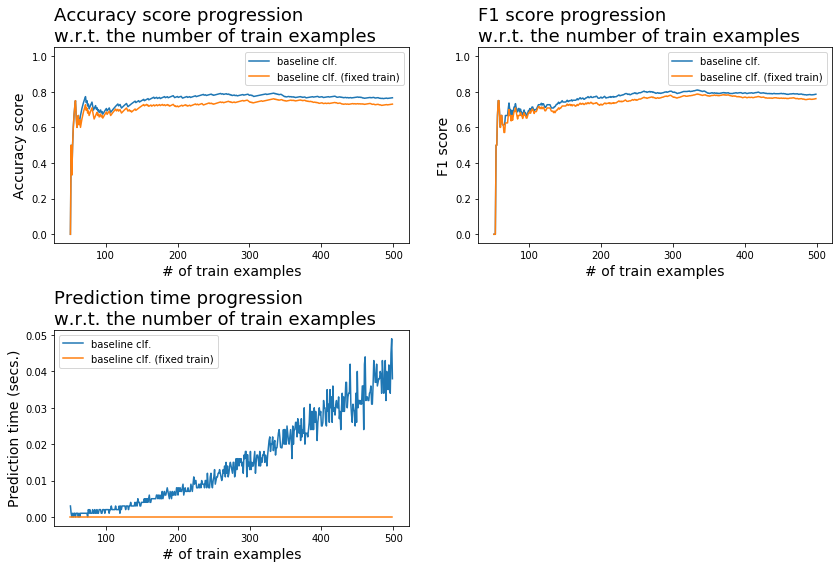

In [13]:
scores = get_scores(y_preds, y_preds_fixedtrain)

plot_metrics(scores, t_preds, t_preds_fixedtrain)

In [14]:
get_scores_info(scores, t_preds, t_preds_fixedtrain)

{'accuracy_score': 0.7562200315830624,
 'accuracy_score_fixedtrain': 0.7212799822789326,
 'f1_score': 0.7625785966832718,
 'f1_score_fixedtrain': 0.7376621185160739,
 't_preds': 0.01560578982035319,
 't_preds_fixedtrain': 0.0}

# Modification of the algorithm

In [16]:
# used algorithms

import lightgbm as lgb
from lazy_pipeline import predict_with_generators
from sklearn.tree import DecisionTreeClassifier

Instead of crossing sets, we use the matrix multiplication function in numpy. Let's add the ability to use algorithms (decision tree and gradient boosting) in lazy pipeline.

In [17]:
def predict_with_dot(x, X_train, Y_train):
    
    X_pos = np.array([x_train for x_train, y in zip(X_train, Y_train) if y])
    X_neg = np.array([x_train for x_train, y in zip(X_train, Y_train) if not y])
    
    pos_dot = np.dot(x,X_pos.T).sum()
    neg_dot = np.dot(x,X_neg.T).sum()

    return pos_dot > neg_dot


def predict_with_model(x, X_train, Y_train, use_model):
    
    model = use_model
    model.fit(X_train,Y_train)    
    res = model.predict([x])

    return res[0]


# I used decision tree for testing, and gradient boosting (without any adjustment of model parameters)

def predict_with_tree(x, X_train, Y_train):
    return predict_with_model(x, X_train, Y_train, DecisionTreeClassifier(max_depth = 6))


def predict_with_boosting(x, X_train, Y_train):
    return predict_with_model(x, X_train, Y_train, lgb.LGBMClassifier(max_depth =4, n_estimators = 100))


def train_lpipe(X, y, n_train, predict_function, update_train):
      
    gen = lpipe.predict_array(X = X, Y = y, n_train = n_train, use_tqdm = False, predict_func = predict_function, update_train = update_train )
    y_preds, t_preds = lpipe.apply_stopwatch(gen)
    
    return y_preds, t_preds


#It’s a high order function, which calls all the algorithms above and counts score

def get_results(predict_function, X, y, n_train):
    
    results = {}
    
    results['model_name'] = predict_function.__name__

    t_start = time.time()
    y_preds, t_preds = train_lpipe(X = X, y = y, n_train = n_train, predict_function = predict_function, update_train = True)
    t_stop = time.time()
    
    results['upd_time'] = t_stop - t_start
    
    t_start = time.time()
    y_preds_fixedtrain, t_preds_fixedtrain = train_lpipe(X = X, y = y, n_train = n_train, predict_function = predict_function, update_train = False)
    t_stop = time.time()
    
    results['fixed_time'] = t_stop - t_start    

    scores = get_scores(y_preds, y_preds_fixedtrain)

    scores_info = get_scores_info(scores, t_preds, t_preds_fixedtrain)
    for key in scores_info:
        results[key] = scores_info[key]
    
    return results

In [18]:
# convert all data to numeric format

X_int = X.astype(int).values

In [19]:
df_results = pd.DataFrame([get_results(predict_function, X_int, y, n_train) for predict_function in [predict_with_dot, predict_with_tree, predict_with_boosting]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [20]:
# final table for comparison

df_results

,model_name,upd_time,fixed_time,accuracy_score,accuracy_score_fixedtrain,f1_score,f1_score_fixedtrain,t_preds,t_preds_fixedtrain
0,predict_with_dot,0.148907,0.037977,0.747410,0.817870,0.581582,0.741756,0.000331,0.000084
1,predict_with_tree,0.727553,0.263840,0.836064,0.785045,0.803344,0.728630,0.001617,0.000584
2,predict_with_boosting,10.372624,4.307353,0.862641,0.807403,0.823205,0.762033,0.023050,0.009572
